In [1]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn

#### SET DING0 SETTINGS

In [3]:
# TODO set in config file
ding0_default=False
retain_all=False #  weil sonst graphen außerhalb des polys unverbunden zum graphen beibehalten werden

In [4]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [5]:
%%time

print('ding0_default', ding0_default)
if ding0_default:
    
    lv_stations, lv_grid_districts = nd.import_mv_grid_districts(session, 
                                                                 mv_grid_districts_no=mv_grid_districts)

else:
    
    graph, geo_load_area, ways_sql_df = nd.import_mv_grid_districts(session, ding0_default, 
                                                                    mv_grid_districts_no=mv_grid_districts,
                                                                    need_parameterization=True,
                                                                    retain_all=False, 
                                                                    truncate_by_edge=False)

ding0_default False
Wall time: 2.93 s


In [6]:
%%time

# to_shape(geo) and get coords
from geoalchemy2.shape import to_shape

ways_sql_df['geometry'] = ways_sql_df.apply(lambda way: to_shape(way.geometry).coords, axis=1)

Wall time: 21 ms


In [7]:
from shapely.geometry import Point


flatten = lambda *n: (e for a in n for e in (flatten(*a) if isinstance(a, (tuple, list)) else (a,)))


nodes = flatten(ways_sql_df.nodes.tolist())
points = flatten(ways_sql_df.geometry.tolist())

nodes_list = list(nodes)
points_list = [list(p) for p in list(points)]
points_list = [Point(item) for sublist in points_list for item in sublist]


In [8]:
import pandas as pd
import geopandas as gpd

geo_load_area = geo_load_area.convex_hull#.buffer(200)

nodes = pd.DataFrame(points_list, index=nodes_list, columns=['geometry'])
nodes_gdf = gpd.GeoDataFrame(nodes, geometry='geometry', crs='epsg:3035')

polys_df = pd.DataFrame({'geometry':geo_load_area}, index=[0])
polys_gdf = gpd.GeoDataFrame(polys_df, geometry='geometry', crs='epsg:3035')

In [9]:
%%time

PointsInPolys = gpd.tools.sjoin(nodes_gdf, polys_gdf, op="within", how='left')


Wall time: 257 ms


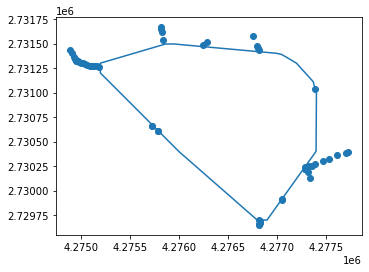

In [10]:
import matplotlib.pyplot as plt

PointsInPolys.loc[PointsInPolys.index_right != 0].plot()
x0, y0 = geo_load_area.exterior.xy
plt.plot(x0,y0)


In [11]:
graph_m = graph.copy()

In [12]:
graph_m.remove_nodes_from(PointsInPolys.loc[PointsInPolys.index_right != 0].index.tolist())

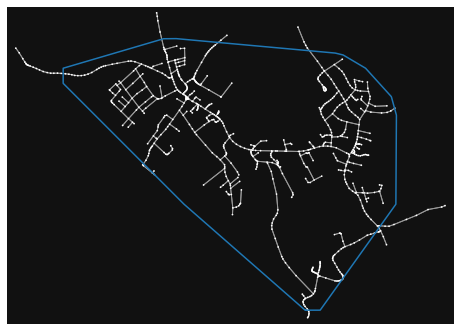

In [13]:
import osmnx as ox
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(graph, node_size=3, show=False, close=False)

x,y = geo_load_area.exterior.xy
plt.plot(x,y)


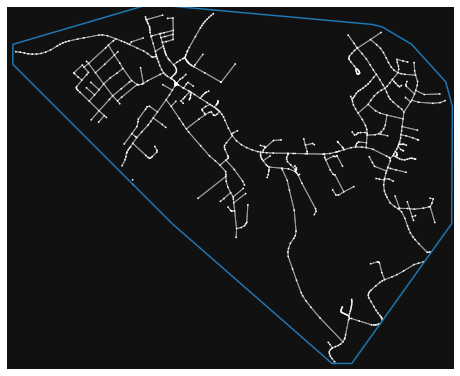

In [14]:
import osmnx as ox
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(graph_m, node_size=3, show=False, close=False)

x,y = geo_load_area.exterior.xy
plt.plot(x,y)
